Use this notebook to perform analysis at the cohort level, where inputs are MCD files.

Search for "TODO" in this notebook to change accordingly to your specific scenrios.

In [1]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import pickle as pkl
import skimage
import yaml
from typing import Union, Optional, Type, Tuple, List, Dict
import sys

#TODO: change to path of the local repository
ROOT_DIR = '/project/DPDS/Xiao_lab/shared/deep_learning_SW_RR/cytof/image_cytof'
sys.path.append(ROOT_DIR)
sys.path.append(os.path.join(ROOT_DIR, 'image_cytof'))


from cytof.hyperion_preprocess import cytof_read_data_roi
# from cytof.hyperion_analysis import 
from cytof import utils 
from utils import process_mcd, save_multi_channel_img, check_feature_distribution, show_color_table

from cytof import classes 
from classes import CytofImage, CytofCohort, CytofImageTiff

/home2/s219733/.conda/envs/cytof-git/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home2/s219733/.conda/envs/cytof-git/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home2/s219733/.conda/envs/cytof-git/lib/python3.8/site-packages/uma

In [2]:
#TODO: change filename here
filename = "path_to_your_mcd_file.mcd"

#TODO: define nuclei and/or membrane based on your data
params = {
    "channels_dict": {'nuclei': ['191Ir(Ir191)', '193Ir(Ir193)'],
                      'membrane': ['CD44(Eu153)']},
}

In [3]:
corrupted, cytof_cohort = process_mcd(filename, params=params)

Slide0
processing slide_id-roi: Slide0-ROI_001
processing slide_id-roi: Slide0-ROI_002
processing slide_id-roi: Slide0-ROI_003
processing slide_id-roi: Slide0-ROI_004
processing slide_id-roi: Slide0-ROI_005
processing slide_id-roi: Slide0-ROI_006
processing slide_id-roi: Slide0-ROI_007
processing slide_id-roi: Slide0-ROI_008
processing slide_id-roi: Slide0-ROI_009
This cohort now contains 6 ROIs, after excluding 3 corrupted ones from the original MCD.


In [4]:
# scale features at the cohort level based on image quantiles
cytof_cohort.scale_feature()

# calculate neighbors using phenograph package
key_pheno = cytof_cohort.clustering_phenograph()


The attribute name of the feature: df_feature_75normed_scaled
Finding 156 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.7054026126861572 seconds
Jaccard graph constructed in 10.88200306892395 seconds
Wrote graph to binary file in 1.1354622840881348 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.588621
After 3 runs, maximum modularity is Q = 0.589934
After 6 runs, maximum modularity is Q = 0.592012
After 17 runs, maximum modularity is Q = 0.596172
Louvain completed 37 runs in 53.94517135620117 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 70.6492371559143 seconds

10 communities found. The dictionary key for phenograph: 75normed_scaled_all_feature_156_all_markers.


Visualization in 2d - cohort-cohort


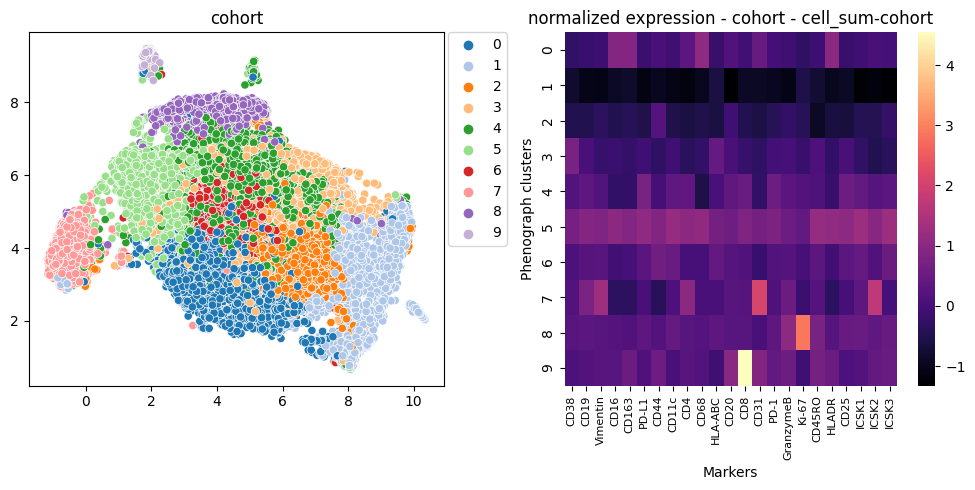

In [5]:
%matplotlib inline
## visualize
df_feats, commus, cluster_protein_exps, figs, figs_scatter, figs_exps = cytof_cohort.vis_phenograph(
    key_pheno=key_pheno,
    level="cohort",
    save_vis=False,
    show_plots=True,
    plot_together=True,
    fig_width=5)

In [6]:
# this performs marker positive analysis for each image in the cohort
_attr_marker_pos = cytof_cohort.generate_summary()

Getting thresholds for cell sum of all markers.


In [7]:
print(cytof_cohort.cytof_images.keys())


dict_keys(['Slide0-ROI_002', 'Slide0-ROI_003', 'Slide0-ROI_004', 'Slide0-ROI_005', 'Slide0-ROI_006', 'Slide0-ROI_009'])


In [8]:
#TODO: choose from the list of slide-roi identifier above
image_name = 'Slide0-ROI_002'
single_image = cytof_cohort[image_name]

Visualizing channels: nuclei, CD11c(Gd154)
Visualizing... 
nuclei in red
CD11c(Gd154) in green



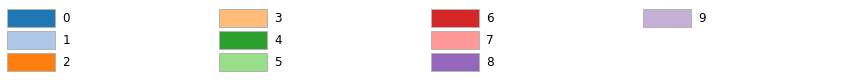

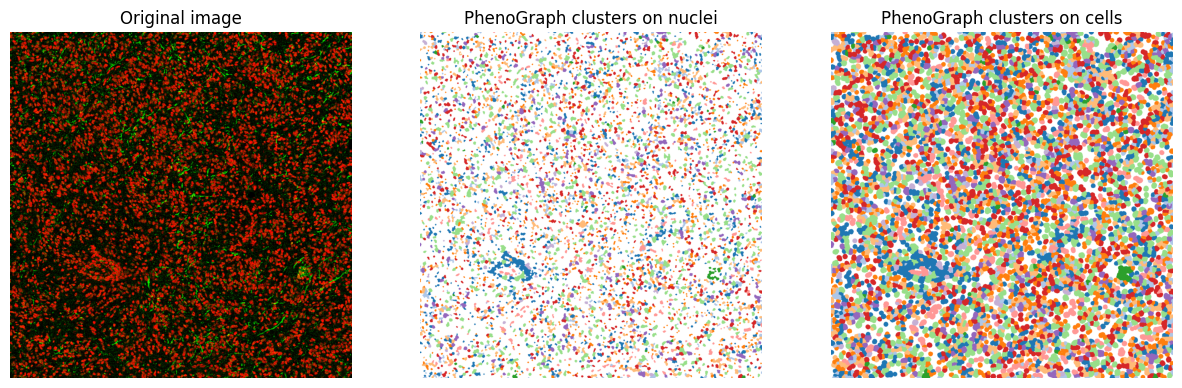

In [9]:
%matplotlib inline

# visualize cells of a single image based on cluster number 
import random
vis_multi, quantiles, color_pool = \
single_image.visualize_channels(channel_names=["nuclei", random.choice(single_image.channels)],#, "CD38(Pr141Di)"], 
    visualize=False)
    
# attch PhenoGraph results to individual ROIs
cytof_cohort.attach_individual_roi_pheno(key_pheno, override=True)

# PhenoGraph clustering visualization
stain_nuclei, stain_cell, color_dict = single_image.visualize_pheno(key_pheno=key_pheno)

show_color_table(color_dict)

fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].imshow(vis_multi)
axs[1].imshow(stain_nuclei)
axs[2].imshow(stain_cell)
axs[0].set_title("Original image")
axs[1].set_title("PhenoGraph clusters on nuclei")
axs[2].set_title("PhenoGraph clusters on cells")
for i in range(3):
    axs[i].axis('off')

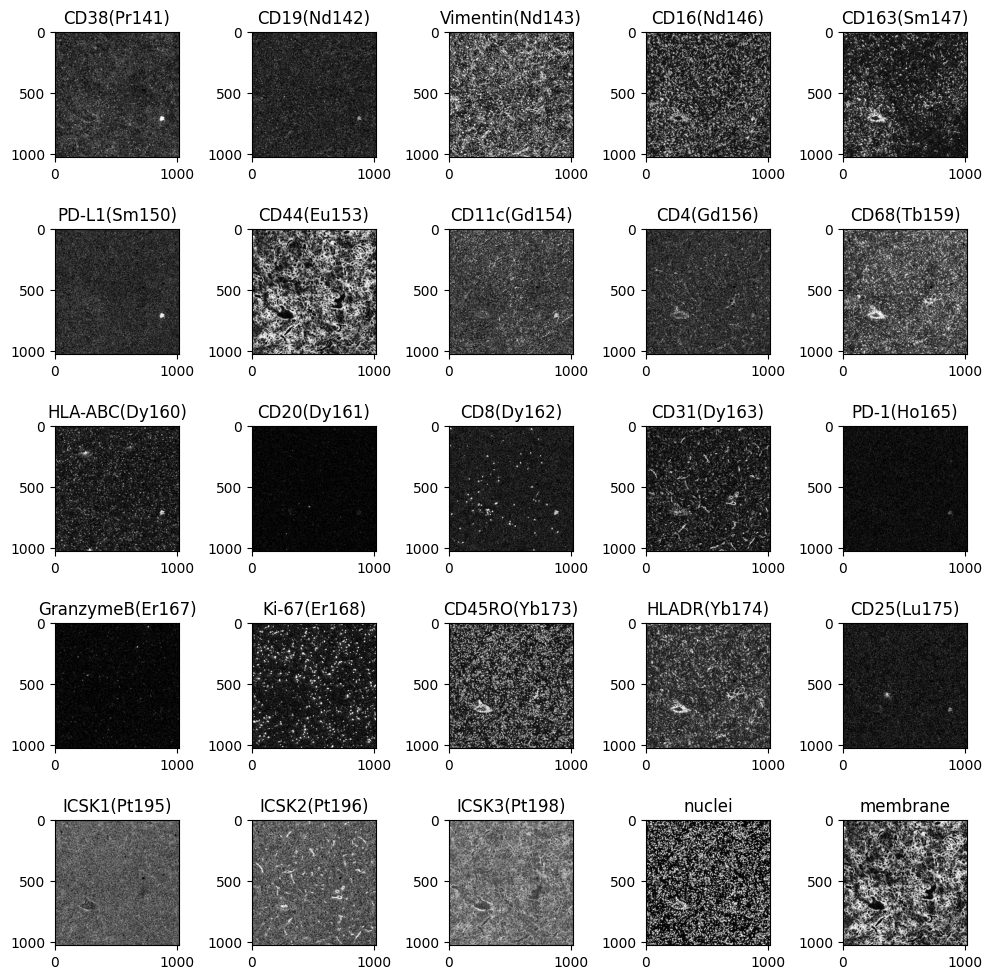

In [10]:
%matplotlib inline

# you can now also perform single image analysis
# completed details found in tutorial-Single-ROI-tiff.ipynb
single_image.check_channels()